# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles in a low density polyethylene _matrix_. Information gained from this process includes the:
- number of particles, $N_p$
- number of agglomerates, $N_a$
- size of particles (longest and shortest chord lengths)
- locations of particles (x,y)
- number of particles per agglomerate, $n$
- factor of agglomeration

where factor of agglomeration is given by:
$$F_a = \frac{N_a \cdot n}{N_p}$$

## Import necessary libraries

In [1]:
import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
import numpy as np                 # NumPy for quick maths

# import seaborn as sb

## Load input data and apply grayscale

We don't need to process input image with 3 color channels as TEM images tend to be grayscale. Now each pixel will be 8 bits ranging from 0 (light) to 255 (dark).

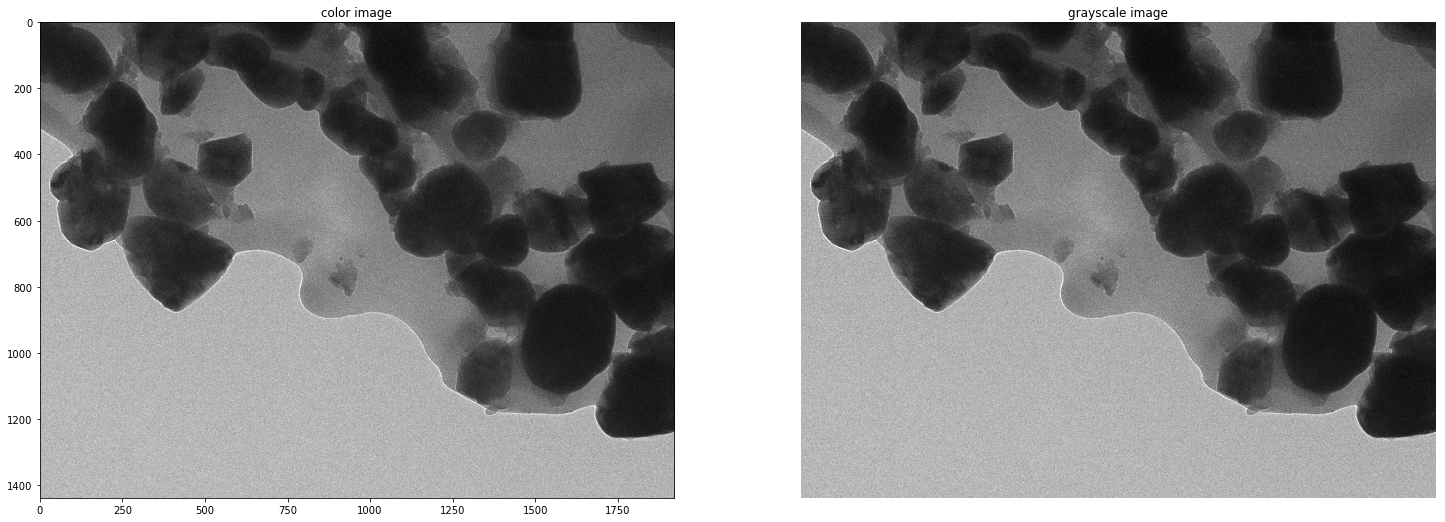

In [2]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

IMAGE_NAME = "TES-II-36a-cropped.tif"
# IMAGE_NAME = "500_scale_BM_20V_200_10=200_20_BM_100 no 10.png"
# IMAGE_NAME = "easy_particles.png" 

# color_image = cv.imread(IMAGE_NAME) # read a color image

# color_image = cv.cvtColor(color_image, cv.COLOR_BGR2RGB)                # convert from BGR to RGB
# not_color_image = cv.cvtColor(color_image, cv.COLOR_RGB2GRAY)           # convert color to grayscale
# gray_image = cv.imread(IMAGE_NAME, cv.IMREAD_GRAYSCALE)

color_image = cv.imread(IMAGE_NAME)
gray_image = cv.cvtColor(color_image, cv.COLOR_BGR2GRAY)

# plot input and grayscale input
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,25))
plt.axis("off")
ax0.imshow(color_image)
ax0.set_title("color image");
# ax1.imshow(gray_image)
ax1.imshow(gray_image, cmap = plt.cm.gray) 
ax1.set_title("grayscale image");

In [3]:
# reshape images to be a ndarray of pixels
# color_pixels = color_image.reshape((color_image.shape[0] * color_image.shape[1], 3))
# gray_pixels = color_image.reshape((gray_image.shape[0] * gray_image.shape[1], 3))

## Gaussian blur 

TEM images have noise (looks like a fine grain filter accross image). To smooth out these grains we apply a gaussian blur.

TODO: explain kernel matrix

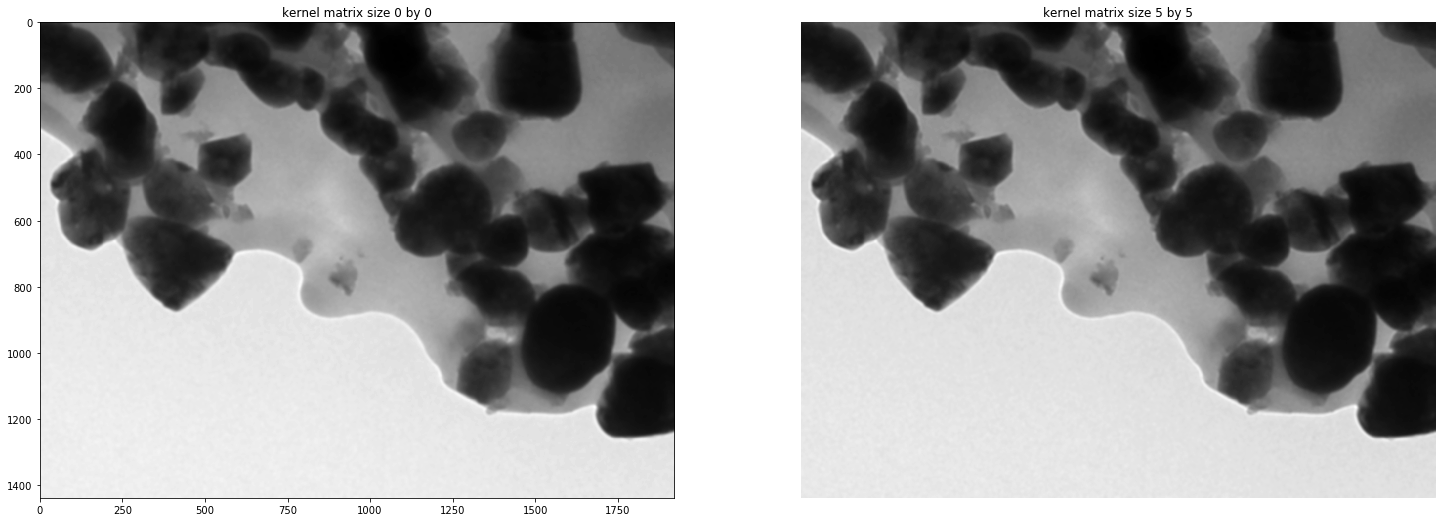

In [4]:
# apply gaussian blur
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,25))
plt.axis("off")
blur_1 = cv.GaussianBlur(gray_image, (0,0) ,cv.BORDER_DEFAULT) 
ax0.imshow(blur_1, cmap = plt.cm.gray) 
ax0.set_title("kernel matrix size 0 by 0")
blur_2 = cv.GaussianBlur(gray_image, (15,15) ,cv.BORDER_DEFAULT) # why only (0,0), (1,1), (5,5) work?
ax1.imshow(blur_2, cmap = plt.cm.gray)
ax1.set_title("kernel matrix size 5 by 5")

## Binary Threshold 

Convert grayscale pixels to only take on values of 0 (light) or 1 (dark). This helps us reduce image size for faster processing but also results in a significant loss of information from the original image.

TODO: explain OTSU's method

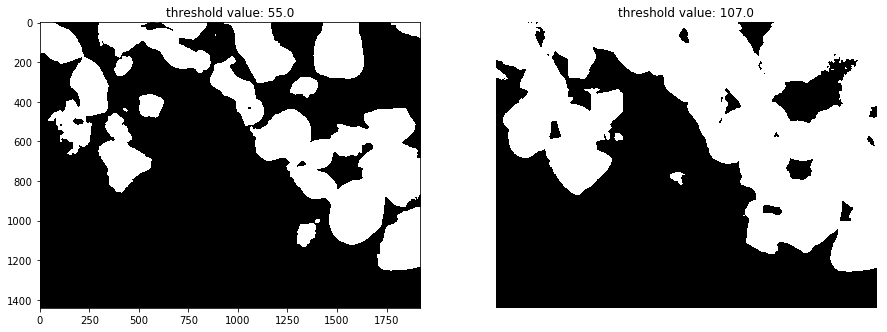

In [5]:
# auto binary threshold color image
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
plt.axis("off")
ret_1, thresh_1 = cv.threshold(blur_1, 55, 255, cv.THRESH_BINARY_INV)
ax0.imshow(thresh_1, cmap = plt.cm.gray)
ax0.set_title("threshold value: " + str(ret_1));

# auto binary threshold grayscale image with Otsu's method
ret_2, thresh_2 = cv.threshold(blur_1, 120, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
ax1.imshow(thresh_2, cmap = plt.cm.gray)
ax1.set_title("threshold value: " + str(ret_2));

## Obtaining sure background and sure foreground

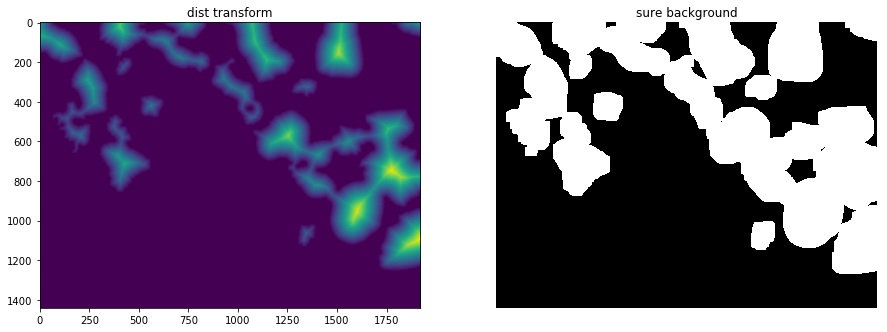

In [6]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
plt.axis("off")

# noise removal
kernel = np.ones((10,10),np.uint8)
opening = cv.morphologyEx(thresh_1,cv.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
ax1.imshow(sure_bg, cmap = plt.cm.gray)
ax1.set_title("sure background")

# Finding distance transform
# Lighter spots mean further away from contours
dist_transform = cv.distanceTransform(opening,cv.DIST_L2, 5)

ax0.imshow(dist_transform)
# ax0.imshow(unknown, cmap = plt.cm.gray)
ax0.set_title("dist transform")

## 1. Contour Agglomerates

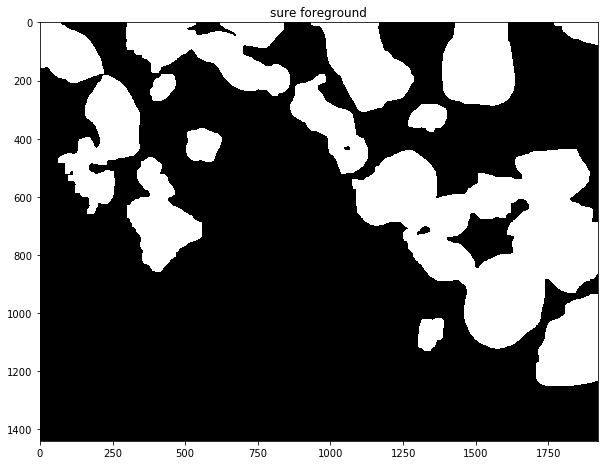

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

ret, sure_fg = cv.threshold(dist_transform, 0.01*dist_transform.max(), 255, 0)
axs.imshow(sure_fg, cmap = plt.cm.gray)
axs.set_title("sure foreground")

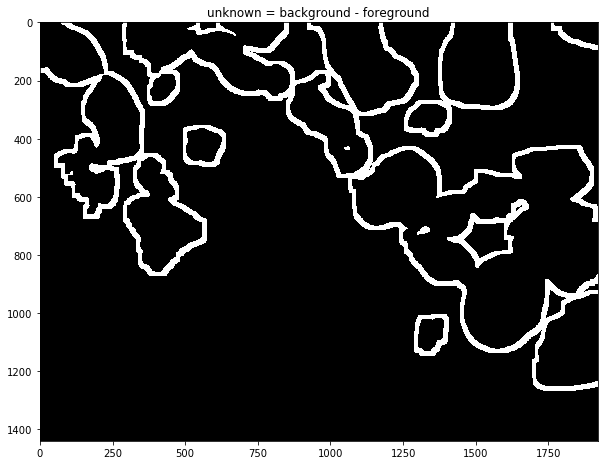

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

plt.imshow(unknown, cmap = plt.cm.gray)
axs.set_title("unknown = background - foreground")

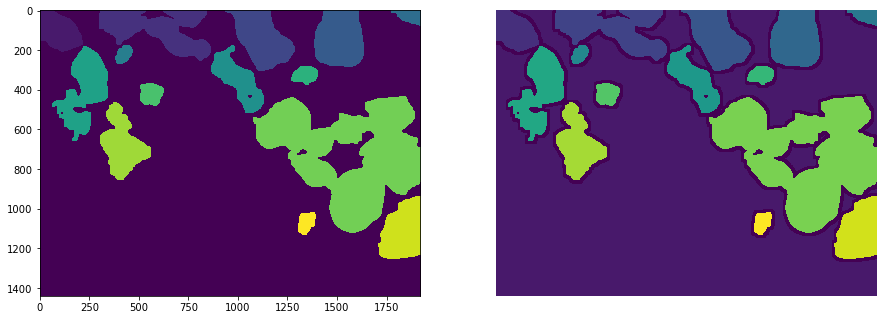

In [9]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))
plt.axis("off")

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
ax0.imshow(markers)

# If unknown's pixel is 255 (white), set corresponding pixel in markers to 0
markers[unknown==255] = 0
ax1.imshow(markers)

In [10]:
# copy input image
color_copy_1 = color_image.copy()

# TODO matrix multiplication optimization

for row in range(len(color_copy_1)):
    for col in range(len(color_copy_1[0])):
        if unknown[row][col] == 255:
            color_copy_1[row][col] = [255,0,0]

we set all boundary pixels to -1, then loop through all of them to make them red

then overlay red pixels on original image

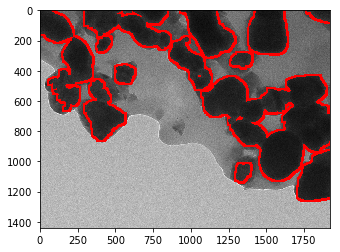

In [11]:
plt.imshow(color_copy_1)

## 2. Contour particles 

Threshold distance transform with a higher value to get particle centers for watershed algorithm

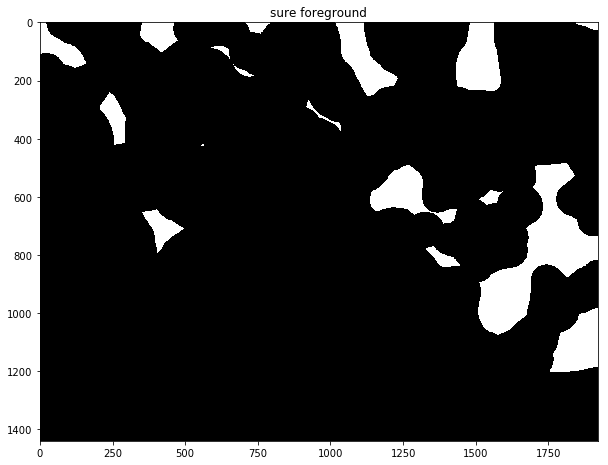

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

ret_2, sure_fg_2 = cv.threshold(dist_transform, 0.35*dist_transform.max(), 255, 0)
axs.imshow(sure_fg_2, cmap = plt.cm.gray)
axs.set_title("sure foreground")

In [13]:
# Finding unknown region
sure_fg_2 = np.uint8(sure_fg_2)
unknown_2 = cv.subtract(sure_bg, sure_fg_2)

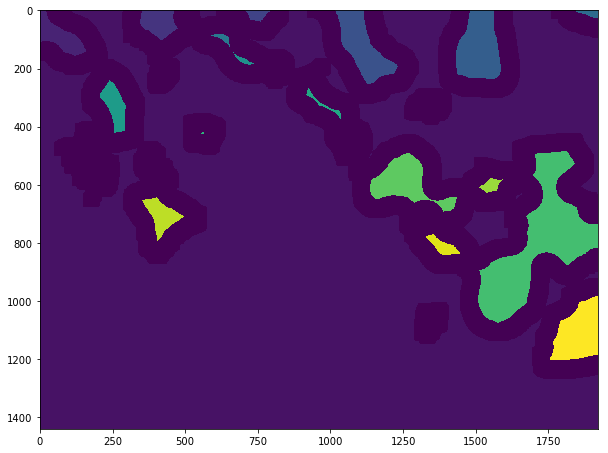

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Marker labelling
ret_2, markers_2 = cv.connectedComponents(sure_fg_2)
# Add one to all labels so that sure background is not 0, but 1
markers_2 = markers_2+1
# Now, mark the region of unknown with zero
markers_2[unknown_2==255] = 0

axs.imshow(markers_2)

Run watershed algorithm from particle centers

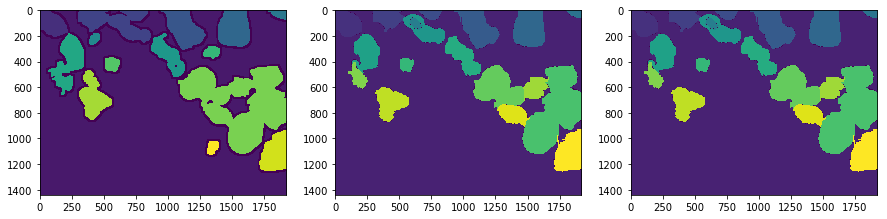

In [15]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,15))

# copy input image
color_copy_2 = color_image.copy()
# blur copied image
blur_copy_2 = cv.GaussianBlur(color_copy_2, (0,0) ,cv.BORDER_DEFAULT) 

blur_markers = cv.watershed(blur_copy_2, markers_2)
blur_copy_2[markers_2 == -1] = [255,0,0]

no_blur_markers = cv.watershed(color_copy_2, markers_2)
color_copy_2[no_blur_markers == -1] = [255,0,0]

ax0.imshow(markers)
ax1.imshow(blur_markers)
ax2.imshow(no_blur_markers)

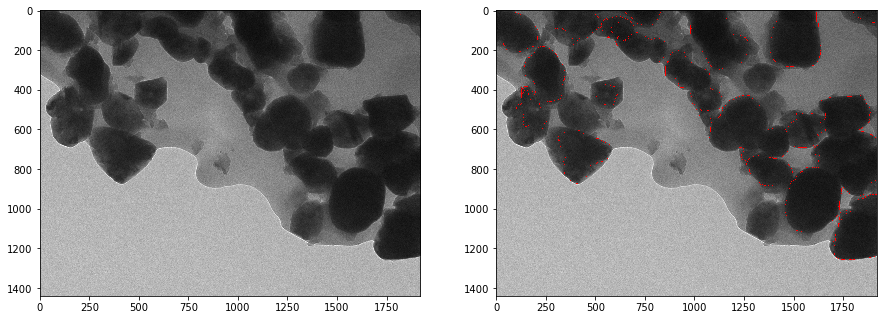

In [16]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,15))

ax0.imshow(color_image)
ax1.imshow(color_copy_2)

## 3. Centerpoints

Thresholding distance transform to get centerpoints

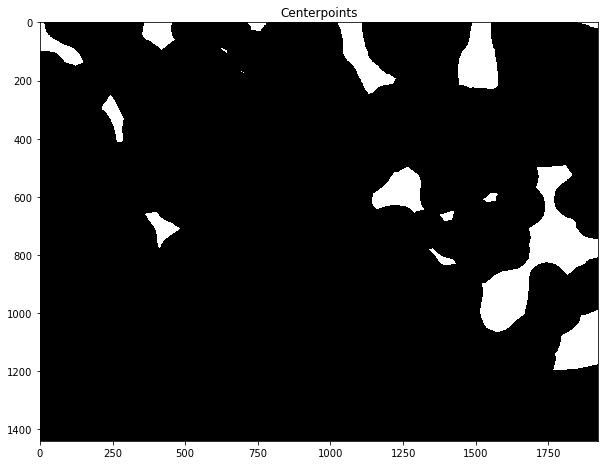

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
ret, centerpoints = cv.threshold(dist_transform, 0.4*dist_transform.max(), 255, 0)

axs.imshow(centerpoints, cmap = plt.cm.gray)
axs.set_title("Centerpoints")